In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [3]:
import os
import sys
import time
import matplotlib.pyplot as plt
import torch

In [3]:
# Set working directory
os.chdir('pytorch-CycleGAN-and-pix2pix/')
sys.path.append('C:/Users/Reach/OneDrive/Desktop/Study/Machine Vission/Project')

In [4]:
sys.argv = [
    'train',
    '--dataroot', 'datasets/photo2',
    '--name', 'photo2cartoon_cyclegan',
    '--model', 'cycle_gan',
    '--display_id', '1',
    '--display_port', '8097',
    '--n_epochs', '10',
    '--n_epochs_decay', '0',
]

In [5]:
# Use GPU if available
if torch.cuda.is_available():
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    print("Using CPU")

Using GPU: NVIDIA GeForce RTX 3050 Laptop GPU


In [6]:
import time
import visdom
from data import create_dataset
from models import create_model
from util.visualizer import Visualizer

from options.train_options import TrainOptions
opt = TrainOptions().parse()
opt.num_threads = 0  # Ensures no multiprocessing in dataloader
opt.display_id = -1

----------------- Options ---------------
               batch_size: 1                             
                    beta1: 0.5                           
          checkpoints_dir: ./checkpoints                 
           continue_train: False                         
                crop_size: 256                           
                 dataroot: datasets/photo2               	[default: None]
             dataset_mode: unaligned                     
                direction: AtoB                          
              display_env: main                          
             display_freq: 400                           
               display_id: 1                             
            display_ncols: 4                             
             display_port: 8097                          
           display_server: http://localhost              
          display_winsize: 256                           
                    epoch: latest                        
              

In [8]:
from options.train_options import TrainOptions
# opt = TrainOptions().parse()
opt.num_threads = 0  # Ensures no multiprocessing in dataloader

vis = visdom.Visdom()  # Connects to Visdom server

# Set number of epochs to 50
opt.n_epochs = 25
opt.n_epochs_decay = 25  # 25 + 25 = 50 total epochs

# Create dataset, model, visualizer
dataset = create_dataset(opt)
model = create_model(opt)
model.setup(opt)
visualizer = Visualizer(opt)

# Create log dictionary
loss_log = {
    'G_A': [], 'G_B': [], 'D_A': [], 'D_B': [],
    'cycle_A': [], 'cycle_B': [], 'idt_A': [], 'idt_B': []
}

total_iters = 0
total_epochs = opt.n_epochs + opt.n_epochs_decay  # Now equals 50

Setting up a new session...


dataset [UnalignedDataset] was created
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
model [CycleGANModel] was created
---------- Networks initialized -------------
[Network G_A] Total number of parameters : 11.378 M
[Network G_B] Total number of parameters : 11.378 M
[Network D_A] Total number of parameters : 2.765 M
[Network D_B] Total number of parameters : 2.765 M
-----------------------------------------------
create web directory ./checkpoints\photo2cartoon_cyclegan\web...


In [9]:
# Start training
for epoch in range(opt.epoch_count, total_epochs + 1):
    print(f"\n========== Epoch {epoch}/{total_epochs} ==========")
    epoch_start_time = time.time()
    epoch_iter = 0
    epoch_losses = {key: 0.0 for key in loss_log}

    print("Starting data loading and training...")
    for i, data in enumerate(dataset):
        total_iters += opt.batch_size
        epoch_iter += opt.batch_size
        model.set_input(data)
        model.optimize_parameters()

        # Get and accumulate losses
        losses = model.get_current_losses()
        for k in epoch_losses:
            epoch_losses[k] += losses[k]

        # Print intermediate losses
        if total_iters % opt.print_freq == 0:
            t_data = 0.0
            t_comp = 0.0
            visualizer.print_current_losses(epoch, epoch_iter, losses, t_comp, t_data)

    # Print epoch summary
    print(f"[Epoch {epoch}] Time Taken: {time.time() - epoch_start_time:.2f} sec")
    for k in epoch_losses:
        avg_loss = epoch_losses[k] / len(dataset)
        loss_log[k].append(avg_loss)
        print(f"  {k}: {avg_loss:.4f}")

    # Save model checkpoint
    if epoch % opt.save_epoch_freq == 0:
        print(f"Saving model at epoch {epoch}")
        model.save_networks(epoch)

    # Save sample visuals
    if epoch % 2 == 0:
        print("Saving visuals...")
        model.compute_visuals()
        visuals = model.get_current_visuals()
        visualizer.display_current_results(visuals, epoch, save_result=True)


========== Epoch 1/50 ==========
Starting data loading and training...
[Epoch 1] Time Taken: 36.91 sec
  G_A: 0.8252
  G_B: 0.7372
  D_A: 0.9333
  D_B: 0.8524
  cycle_A: 2.2329
  cycle_B: 2.3558
  idt_A: 1.1366
  idt_B: 1.0685

========== Epoch 2/50 ==========
Starting data loading and training...
(epoch: 2, iters: 39, time: 0.000, data: 0.000) D_A: 0.202 G_A: 0.274 cycle_A: 0.675 idt_A: 0.378 D_B: 0.315 G_B: 0.372 cycle_B: 0.793 idt_B: 0.327 
[Epoch 2] Time Taken: 35.85 sec
  G_A: 0.4169
  G_B: 0.3597
  D_A: 0.3761
  D_B: 0.3667
  cycle_A: 1.1776
  cycle_B: 1.1380
  idt_A: 0.5053
  idt_B: 0.5303
Saving visuals...

========== Epoch 3/50 ==========
Starting data loading and training...
[Epoch 3] Time Taken: 36.51 sec
  G_A: 0.3328
  G_B: 0.3528
  D_A: 0.3030
  D_B: 0.3514
  cycle_A: 1.1018
  cycle_B: 1.0457
  idt_A: 0.4576
  idt_B: 0.4898

========== Epoch 4/50 ==========
Starting data loading and training...
(epoch: 4, iters: 17, time: 0.000, data: 0.000) D_A: 0.219 G_A: 0.387 cycle_A

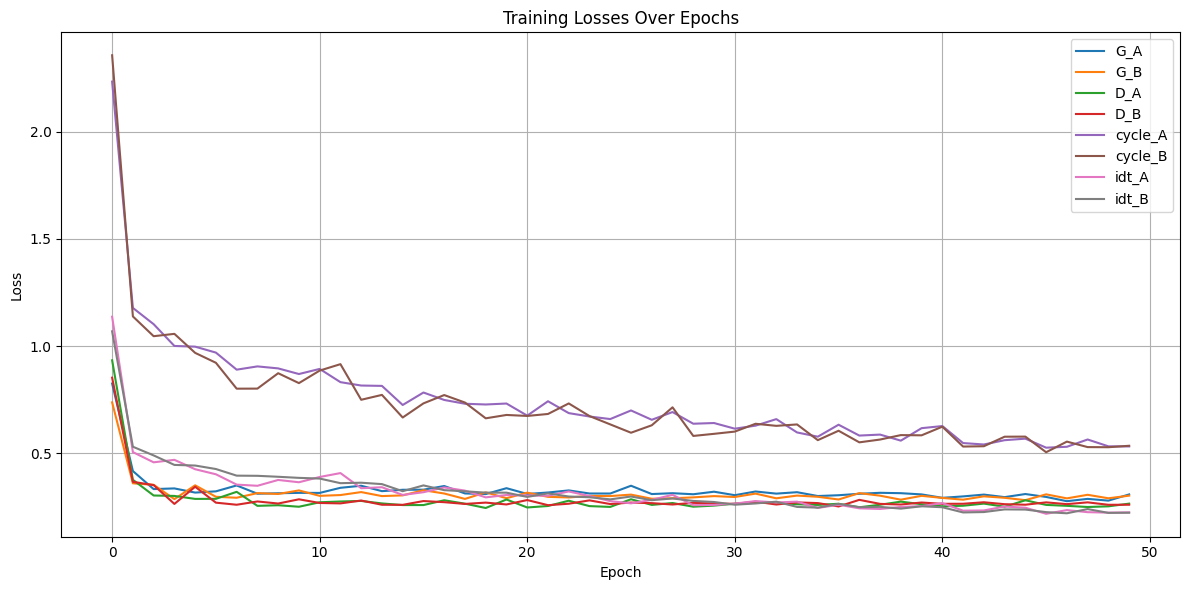

In [10]:
# ----------------------------------------
# Plotting Loss Graphs after training
# ----------------------------------------
plt.figure(figsize=(12, 6))
for k, v in loss_log.items():
    plt.plot(v, label=k)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Losses Over Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("loss_plot.png")
plt.show()

In [11]:
# Save Generators
torch.save(model.netG_A.state_dict(), "netG_A.pth")  # A → B
torch.save(model.netG_B.state_dict(), "netG_B.pth")  # B → A

# Save Discriminators
torch.save(model.netD_A.state_dict(), "netD_A.pth")
torch.save(model.netD_B.state_dict(), "netD_B.pth")

print("✅ Saved netG_A, netG_B, netD_A, and netD_B successfully!")

✅ Saved netG_A, netG_B, netD_A, and netD_B successfully!


Testing

In [4]:
!python test.py --dataroot ./datasets/photo2/testA \
                --name photo2cartoon_cyclegan \
                --model test \
                --epoch 50


----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 1                             
          checkpoints_dir: ./checkpoints                 
                crop_size: 256                           
                 dataroot: ./datasets/photo2/testA       	[default: None]
             dataset_mode: single                        
                direction: AtoB                          
          display_winsize: 256                           
                    epoch: 50                            	[default: latest]
                     eval: False                         
                  gpu_ids: 0                             
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 3                             
                  isTrain: False                         	[default: None]
                load_iter: 0          

test.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.netG.load_state_dict(torch.load(netG_A_path, map_location=model.device))


Input: img_061_real.png → Output: img_061_fake.png


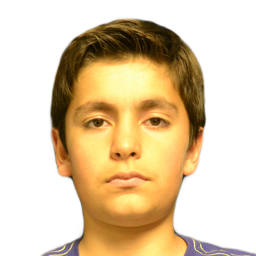

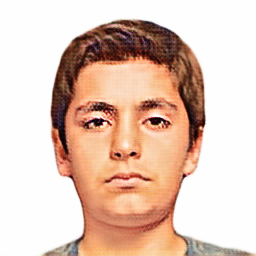

Input: img_062_real.png → Output: img_062_fake.png


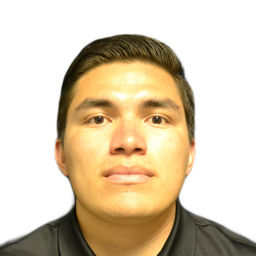

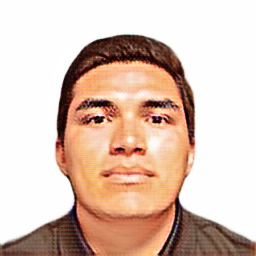

Input: img_063_real.png → Output: img_063_fake.png


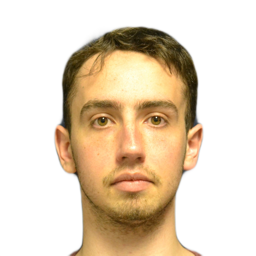

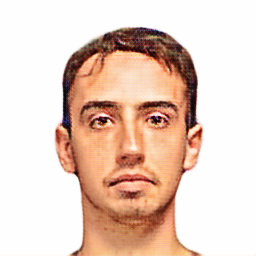

Input: img_064_real.png → Output: img_064_fake.png


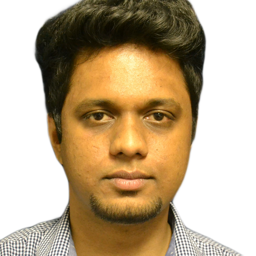

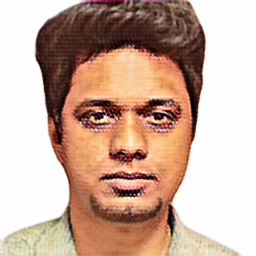

Input: img_065_real.png → Output: img_065_fake.png


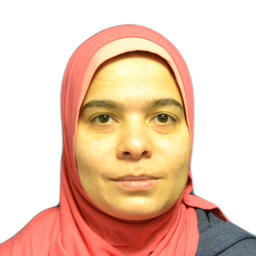

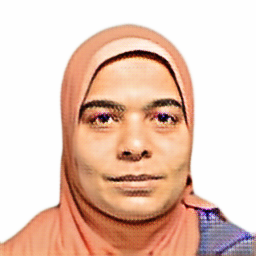

Input: img_066_real.png → Output: img_066_fake.png


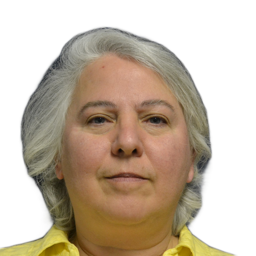

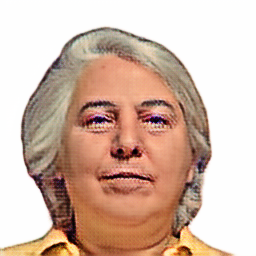

Input: img_067_real.png → Output: img_067_fake.png


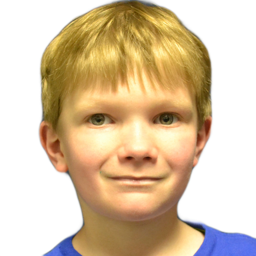

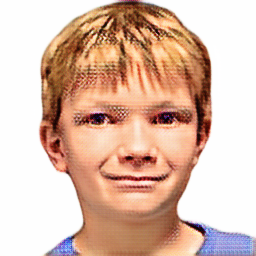

Input: img_068_real.png → Output: img_068_fake.png


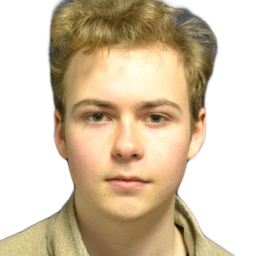

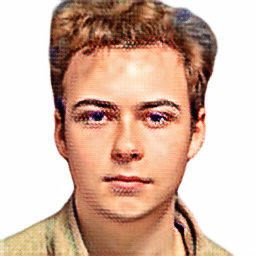

Input: img_069_real.png → Output: img_069_fake.png


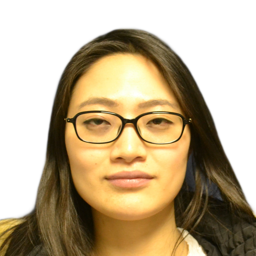

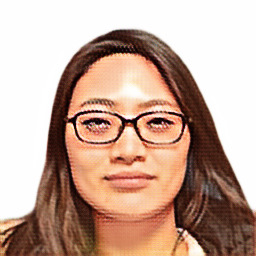

Input: img_070_real.png → Output: img_070_fake.png


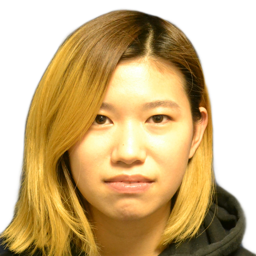

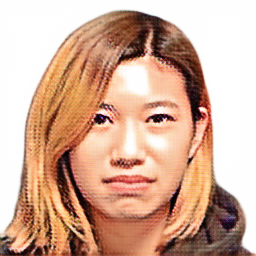

Input: img_071_real.png → Output: img_071_fake.png


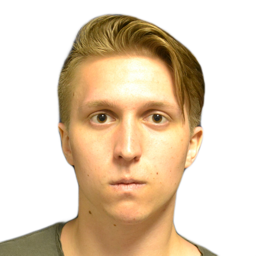

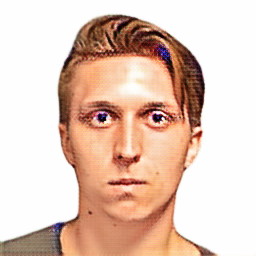

Input: img_072_real.png → Output: img_072_fake.png


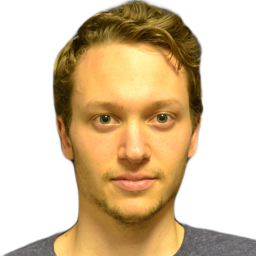

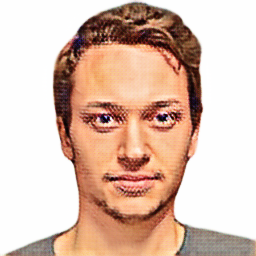

Input: img_073_real.png → Output: img_073_fake.png


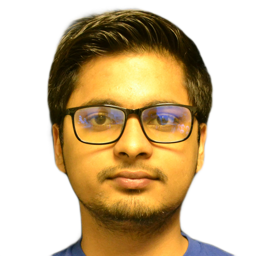

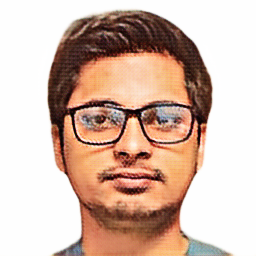

Input: img_074_real.png → Output: img_074_fake.png


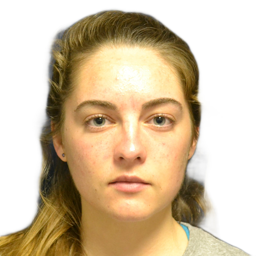

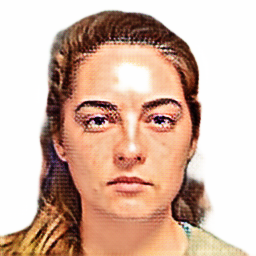

Input: img_075_real.png → Output: img_075_fake.png


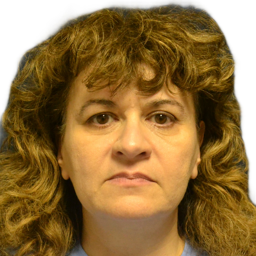

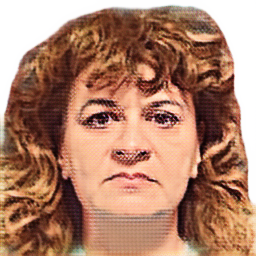

In [21]:
import os
from IPython.display import Image, display

results_dir = './results/photo2cartoon_cyclegan/test_50/images'

# Show input and generated output
for fname in os.listdir(results_dir):
    if fname.endswith('_fake.png'):
        input_name = fname.replace('_fake', '_real')
        print(f"Input: {input_name} → Output: {fname}")
        display(Image(os.path.join(results_dir, input_name)))
        display(Image(os.path.join(results_dir, fname)))

Found 15 image pairs


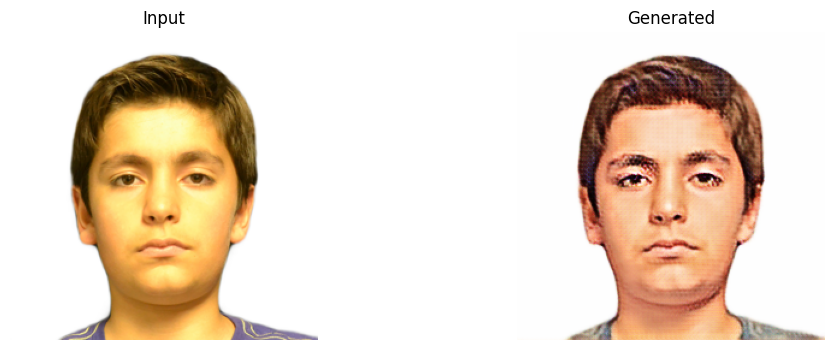

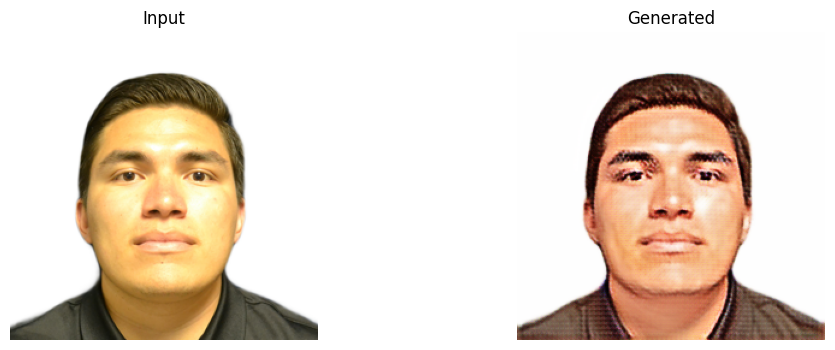

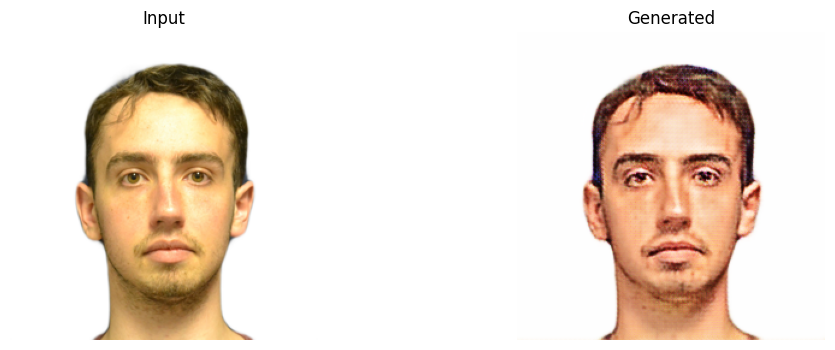

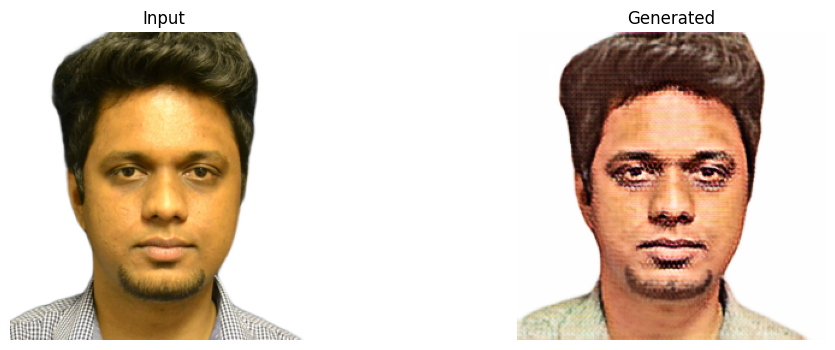

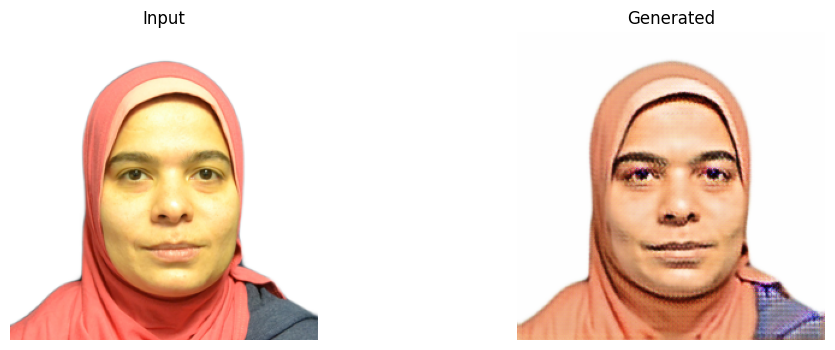

In [26]:
import os
from IPython.display import display, HTML
from PIL import Image
import matplotlib.pyplot as plt

# Path to your test images
results_dir = './results/photo2cartoon_cyclegan/test_50/images'

# Gather input-output pairs
pairs = []
for fname in os.listdir(results_dir):
    if fname.endswith('_fake.png'):
        input_name = fname.replace('_fake', '_real')
        real_name = fname.replace('_fake', '_real')  # Optional: for comparison
        input_path = os.path.join(results_dir, input_name)
        output_path = os.path.join(results_dir, fname)
        real_path = os.path.join(results_dir, real_name)
        if os.path.exists(input_path):
            pairs.append((input_path, output_path, real_path if os.path.exists(real_path) else None))

# Print summary
print(f"Found {len(pairs)} image pairs")

# Display a few samples
for i, (input_img, fake_img, real_img) in enumerate(pairs[:5]):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    
    axs[0].imshow(Image.open(input_img))
    axs[0].set_title("Input")
    axs[0].axis('off')
    
    axs[1].imshow(Image.open(fake_img))
    axs[1].set_title("Generated")
    axs[1].axis('off')
    plt.show()


In [27]:
import pickle

# Save the image path pairs
with open('test_results_paths.pkl', 'wb') as f:
    pickle.dump(pairs, f)

print("Saved test image paths to test_results_paths.pkl")


Saved test image paths to test_results_paths.pkl


In [29]:
# ignore this
# For furture use

# import pickle

# # For path-only version
# with open('test_results_paths.pkl', 'rb') as f:
#     pairs = pickle.load(f)

# # OR, for image-data version
# with open('test_results_images.pkl', 'rb') as f:
#     image_data = pickle.load(f)

SyntaxError: invalid syntax (3204998488.py, line 1)